In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from itertools import islice
import statsmodels.api as sm
sns.set()
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from kneed import KneeLocator

In [2]:
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)
matplotlib.style.use('ggplot')

In [3]:
fmt = '%Y-%m-%d %H:%M:%S'

In [4]:
def parse_timestamp(el):
    b = datetime.datetime.strptime(el, fmt)
    return b

In [5]:
def trim_latlng(x):
    return round(x,4)

In [33]:
url = "/bigdata/jelicicna/clustering_datasets/clustering_data_2020-01.csv"
df = pd.read_csv(url, sep=';', low_memory=False)

In [34]:
# x marks points for clustering
x = pd.DataFrame()
x['lat'] = df['lat_begin']
x['lng'] = df['lng_begin']
x['location_id'] = df['origin_id']
x['ride_id'] = df['ride_id']

In [35]:
df_x = pd.DataFrame()
bikes = set(df['bike_id'])
lat = []
lng = []
locations = []
rides = []

for b in bikes:
    last_row = df[df['bike_id']==b]
    last_x = last_row.iloc[-1]
    lat.append(last_x['lat_end'])
    lng.append(last_x['lng_end'])
    locations.append(last_x['destination_id'])
    rides.append(last_x['ride_id'])
df_x['lat'] = lat
df_x['lng'] = lng
df_x['location_id'] = locations
df_x['ride_id'] = rides

In [36]:
x_points = pd.concat([x,df_x], ignore_index=True)
x_points.head()

,lat,lng,location_id,ride_id
0,50.932058,6.988541,15405.0,0.0
1,50.936326,6.986125,16502.0,1.0
2,50.932037,6.988254,32762.0,2.0
3,50.933312,6.982806,25309.0,3.0
4,50.933619,6.977495,38004.0,4.0


In [37]:
#---------
#
# The cell should be skipped in the first run until missing destinations are calculated
#----------------------------------------------------------------------------------------
x_points = x_points.append(missing_destinations, ignore_index=True)

In [38]:
x = x_points.iloc[:,0:2]

## Deciding on an optimal number of clusters

### Elbow method

In [11]:
potential_k = []
for k in range(10,160,10):
    potential_k.append(k)

In [12]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in potential_k:
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(x)
    sse.append(kmeans.inertia_)

In [13]:
font = {'font': 'verdana',
        'color':  'black',
        'weight': 'normal',
        'size': 12,
        }
font2 = {'font': 'verdana',
         'color':  'black',
         'weight': 'normal',
         'size': 16,
        }

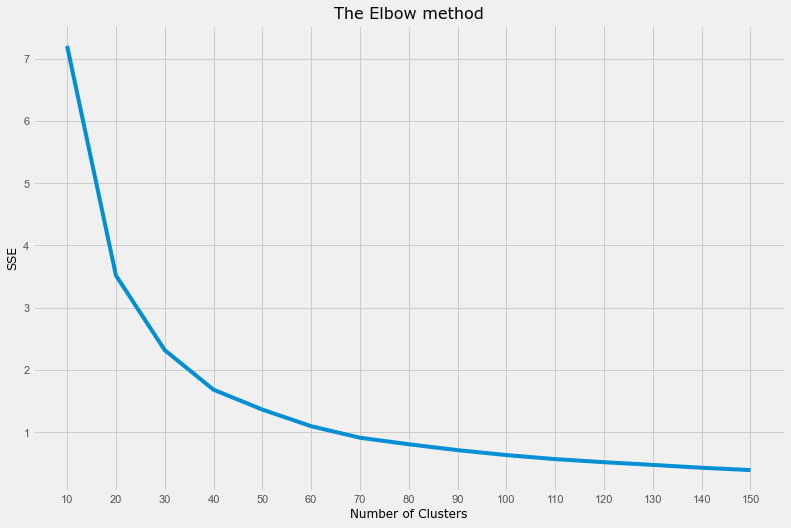

In [14]:
plt.style.use("fivethirtyeight")
plt.plot(potential_k, sse)
plt.xticks(potential_k)
plt.xlabel("Number of Clusters", fontdict=font)
plt.ylabel("SSE", fontdict=font)
plt.title("The Elbow method", fontdict=font2)
plt.show()

In [15]:
kl = KneeLocator(range(10,160,10), sse, curve="convex", direction="decreasing")
kl.elbow

40

In [16]:
#assigning the ideal result of the elbow method as a future k for clustering
clust_k = kl.elbow

## Clustering K-means

In [39]:
x = x.to_numpy()

In [40]:
kmeans = KMeans(clust_k)
kmeans.fit(x)

KMeans(n_clusters=40)

In [41]:
identified_clusters = kmeans.fit_predict(x)
identified_clusters

array([37, 37, 37, ..., 38,  0, 37], dtype=int32)

In [42]:
len(identified_clusters)

57623

In [43]:
len(x_points)

57623

In [44]:
x_points['cluster'] = identified_clusters

In [45]:
df_merge_x = pd.DataFrame()
df_merge_x['location_id'] = x_points['location_id']
df_merge_x['cluster'] = x_points['cluster']

In [46]:
df.rename({'origin_id': 'location_id'}, axis= 1, inplace= True) #temporary change

In [47]:
df_clusters = pd.DataFrame()
df_clusters = pd.merge(df, df_merge_x, on='location_id', how='left')

In [48]:
df_clusters.drop_duplicates(subset=['ride_id'], inplace=True)

In [49]:
#reverting the change of origin name and adding the same for the cluster
df_clusters.rename({'location_id':'origin_id', 'cluster':'origin_cluster'}, axis=1, inplace=True)

#temporary change for destinations
df_clusters.rename({'destination_id':'location_id'}, axis=1, inplace=True)

In [50]:
df_clusters = pd.merge(df_clusters, df_merge_x, on='location_id', how='left')
df_clusters.drop_duplicates(subset=['ride_id'], inplace=True)

In [51]:
#reverting the change of destination name and adding the same for the cluster
df_clusters.rename({'location_id':'destination_id', 'cluster':'destination_cluster'}, axis=1, inplace=True)

### Run to compute missing destinations, re-run all the cells -----

In [30]:
temp = df_clusters[df_clusters['destination_cluster'].isna()]

In [31]:
missing_destinations = pd.DataFrame()
missing_destinations['lat'] = temp['lat_end']
missing_destinations['lng'] = temp['lng_end']
missing_destinations['location_id'] = temp['destination_id']
missing_destinations['ride_id'] = temp['ride_id']

In [32]:
missing_destinations.head()

,lat,lng,location_id,ride_id
12,50.937086,6.980346,20054,5
14,50.932995,6.976686,27300,7
17,50.933340,6.973975,17079,9
51,50.934854,6.960032,83,21
68,50.946891,6.939716,24604,28


## --------------------------------------------

In [52]:
df_clusters.head()

,ride_id,bike_id,origin_id,destination_id,lat_begin,lng_begin,lat_end,lng_end,ride_time,distance,origin_cluster,destination_cluster
0,0,0,15405,16502,50.932058,6.988541,50.936326,6.986125,6.0,504.0,37,37
3,1,0,16502,32762,50.936326,6.986125,50.932037,6.988254,5.0,500.0,37,37
7,2,0,32762,25969,50.932037,6.988254,50.933224,6.982801,7.0,404.0,37,37
8,3,0,25309,38004,50.933312,6.982806,50.933619,6.977495,5.0,374.0,37,9
9,4,0,38004,8996,50.933619,6.977495,50.936199,6.987294,9.0,744.0,9,37


In [53]:
df_g = df_clusters[['ride_time','origin_cluster','destination_cluster']]

In [54]:
df_g = df_g.groupby(['origin_cluster','destination_cluster']).count()

In [55]:
df_g.reset_index(inplace=True)

In [56]:
df_g.rename({'ride_time':'ride_count'}, axis=1, inplace=True)
df_g.head()

,origin_cluster,destination_cluster,ride_count
0,0,0,306
1,0,1,8
2,0,2,2
3,0,4,18
4,0,5,13


In [57]:
df_g['origin_cluster'].value_counts() #the most often clusters of origin

1     40
19    39
4     39
10    39
8     39
16    38
21    38
5     37
31    37
28    37
9     36
22    36
38    35
25    35
33    34
32    34
2     34
11    34
18    34
6     32
0     32
37    32
35    32
12    31
27    30
17    30
15    30
14    30
24    30
7     30
20    29
29    28
30    28
34    27
36    27
23    23
39    22
26    21
3     20
13    18
Name: origin_cluster, dtype: int64

In [58]:
df_g.sort_values(by=['ride_count'], ascending=False).head()

,origin_cluster,destination_cluster,ride_count
208,6,6,670
672,20,11,565
1253,38,38,564
389,11,11,530
396,11,20,518


In [59]:
x_grouped = x_points.groupby(['cluster']).mean()
x_grouped.drop(['location_id', 'ride_id'], axis=1, inplace=True)
x_grouped.rename({'lat': 'centroid_lat', 'lng': 'centroid_lng'}, axis=1, inplace=True)
x_grouped.reset_index(inplace=True)

In [60]:
x_grouped2 = x_points.groupby(['cluster']).count()
x_grouped2.drop(['lat', 'lng', 'location_id'], axis=1, inplace=True)
x_grouped2.rename({'ride_id': 'ride_count'}, axis=1, inplace=True)
x_grouped2.reset_index(inplace=True)

In [61]:
grouped_df = pd.merge(x_grouped, x_grouped2, on='cluster', how='outer')
grouped_df.head()

,cluster,centroid_lat,centroid_lng,ride_count
0,0,50.957471,6.900928,1328
1,1,50.952317,6.958016,1712
2,2,50.923213,6.953751,1180
3,3,50.944177,7.020706,611
4,4,50.941274,6.946040,1955


In [62]:
final_df = pd.merge(x_points, grouped_df, on='cluster', how='left')
final_df.head()

,lat,lng,location_id,ride_id,cluster,centroid_lat,centroid_lng,ride_count
0,50.932058,6.988541,15405.0,0.0,37,50.932574,6.985815,1509
1,50.936326,6.986125,16502.0,1.0,37,50.932574,6.985815,1509
2,50.932037,6.988254,32762.0,2.0,37,50.932574,6.985815,1509
3,50.933312,6.982806,25309.0,3.0,37,50.932574,6.985815,1509
4,50.933619,6.977495,38004.0,4.0,9,50.938243,6.975198,1895


Text(0.5, 1.0, 'Jan 2021')

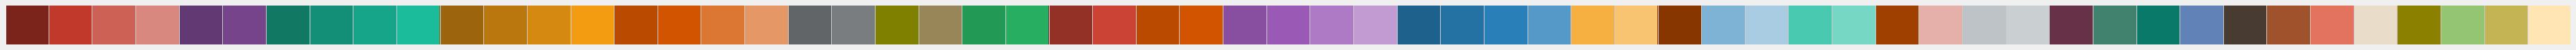

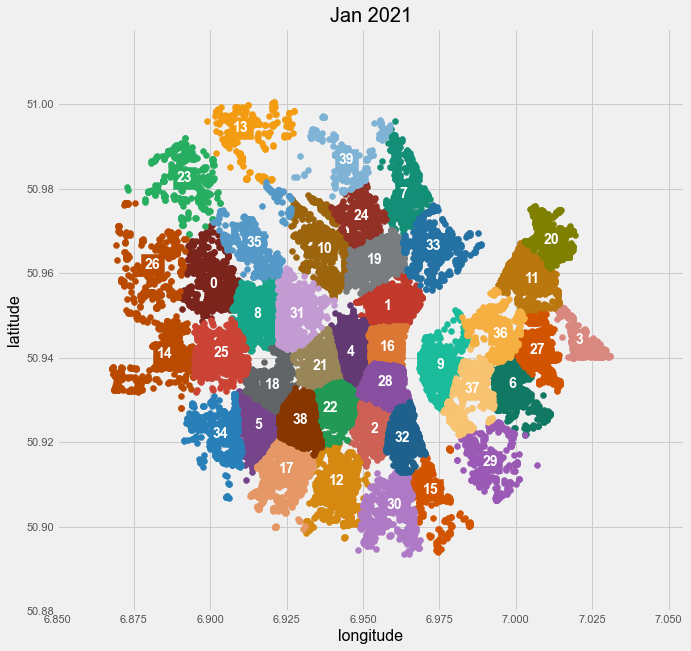

In [63]:
customPalette = ['#7b241c', '#c0392b', '#cd6155', '#d98880', '#633974', '#76448a',
                 '#117864', '#148f77', '#17a589', '#1abc9c',
                 '#9c640c', '#b9770e', '#d68910', '#f39c12',
                 '#ba4a00', '#d35400', '#dc7633', '#e59866', '#626567', '#797d7f',
                 '#808000', '#988558', '#229954', '#27ae60', '#943126', '#cb4335', '#ba4a00', '#d35400',
                 '#884ea0', '#9b59b6', '#af7ac5', '#c39bd3',
                 '#1f618d', '#2471a3', '#2980b9', '#5499c7', '#f5b041', '#f8c471', '#873600','#7fb3d5', '#a9cce3',
                 '#48c9b0', '#76d7c4', '#a04000', '#e6b0aa', '#bdc3c7', '#cacfd2',
                 '#673147', '#40826D', '#097969', '#6082B6', '#483C32', '#A0522D',
                 '#E3735E', '#E9DCC9', '#8B8000', '#93C572', '#C4B454', '#FFE5B4']
sns.set_palette(customPalette)
sns.palplot(customPalette)

labels = set(x_points['cluster'].to_list())

#create a new figure
f = plt.figure(figsize=(10,10))
plt.xlim(6.85, 7.055)
plt.ylim(50.88, 51.018)

#loop through labels and plot each cluster
for l in labels:

    #add data points 
    plt.scatter(x=x_points.loc[x_points['cluster']==l, 'lng'], 
                y=x_points.loc[x_points['cluster']==l, 'lat'], 
                color=customPalette[l], 
                alpha=1)
    
    #add label
    plt.annotate(l, 
                 x_points.loc[x_points['cluster']==l,['lng','lat']].mean(),
                 horizontalalignment='center',
                 verticalalignment='center',
                 size=14, weight='bold',
                 color='white',
                 backgroundcolor=customPalette[l]) 
plt.xlabel('longitude', fontsize=16, color='#000000')
plt.ylabel('latitude', fontsize=16, color='#000000')
plt.title('Jan 2021', fontsize=20, color='#000000')

In [64]:
#final_df.to_csv('./final_data_2020-01.csv', sep=';', index=False)

### Agglomerative Clustering

In [65]:
from scipy.cluster.hierarchy import dendrogram

In [66]:
# instantiate Agglomerative Clustering instance
clustering_model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

# call fit method with array of sample coordinates passed as a parameter
categories = clustering_model.fit(x)

categories.labels_

array([55259, 44884, 54282, ...,     1,     2,     0])

In [67]:
clustering_model.children_

array([[  3316,  51956],
       [ 13145,  24536],
       [ 35737,  45424],
       ...,
       [115234, 115238],
       [115241, 115242],
       [115239, 115243]])

In [68]:
clustering_model.distances_.max()

8.687830210832677

In [69]:
clustering_model.distances_.min()

0.0

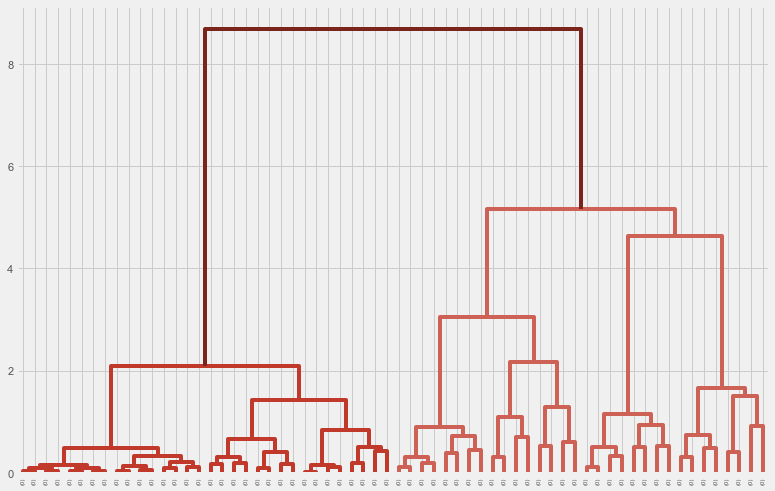

In [70]:
labels = np.zeros((len(clustering_model.children_), 1))
d = np.hstack((clustering_model.children_, clustering_model.distances_.reshape(-1,1), labels))
dendrogram(d, truncate_mode='level', p=5)
None

In [ ]:
# instantiate Agglomerative Clustering instance
clustering_model = AgglomerativeClustering(distance_threshold=0.3, n_clusters=None)

# call fit method with array of sample coordinates passed as a parameter
categories = clustering_model.fit(x)

categories.labels_

In [ ]:
x_points.rename({'cluster': 'cluster_kmns'}, axis= 1, inplace= True)

In [ ]:
len(set(categories.labels_)) #number of clusters for the month

In [ ]:
x_points['cluster'] = categories.labels_

In [ ]:
df_merge_x = pd.DataFrame()
df_merge_x['location_id'] = x_points['location_id']
df_merge_x['cluster'] = x_points['cluster']

In [ ]:
df_clusters.rename({'origin_cluster': 'origin_cluster_kmns', 'destination_cluster': 'destination__cluster_kmns'}, axis= 1, inplace= True)

In [ ]:
df_clusters.rename({'origin_id': 'location_id'}, axis= 1, inplace= True) #temporary change
df_clusters = pd.merge(df_clusters, df_merge_x, on='location_id', how='left')

df_clusters.drop_duplicates(subset=['ride_id'], inplace=True)

#reverting the change of origin name and adding the same for the cluster
df_clusters.rename({'location_id':'origin_id', 'cluster':'origin_cluster'}, axis=1, inplace=True) 

#temporary change for destinations
df_clusters.rename({'destination_id':'location_id'}, axis=1, inplace=True)

df_clusters = pd.merge(df_clusters, df_merge_x, on='location_id', how='left')

df_clusters.drop_duplicates(subset=['ride_id'], inplace=True)

#reverting the change of destination name and adding the same for the cluster
df_clusters.rename({'location_id':'destination_id', 'cluster':'destination_cluster'}, axis=1, inplace=True)

In [ ]:
df_clusters.head()

In [ ]:
df_g = df_clusters[['ride_time','origin_cluster','destination_cluster']]
df_g = df_g.groupby(['origin_cluster','destination_cluster']).count()
df_g.reset_index(inplace=True)
df_g.rename({'ride_time':'ride_count'}, axis=1, inplace=True)
df_g.head()

In [ ]:
customPalette = ['#7b241c', '#c0392b', '#cd6155', '#d98880', '#633974', '#76448a',
                 '#117864', '#148f77', '#17a589', '#1abc9c',
                 '#9c640c', '#b9770e', '#d68910', '#f39c12',
                 '#ba4a00', '#d35400', '#dc7633', '#e59866', '#626567', '#797d7f',
                 '#808000', '#988558', '#229954', '#27ae60', '#943126', '#cb4335', '#ba4a00', '#d35400',
                 '#884ea0', '#9b59b6', '#af7ac5', '#c39bd3',
                 '#1f618d', '#2471a3', '#2980b9', '#5499c7', '#f5b041', '#f8c471', '#873600','#7fb3d5', '#a9cce3',
                 '#48c9b0', '#76d7c4', '#a04000', '#e6b0aa', '#bdc3c7', '#cacfd2',
                 '#673147', '#40826D', '#097969', '#6082B6', '#483C32', '#A0522D',
                 '#E3735E', '#E9DCC9', '#8B8000', '#93C572', '#C4B454', '#FFE5B4']
sns.set_palette(customPalette)
sns.palplot(customPalette)

labels = set(x_points['cluster'].to_list())

#create a new figure
plt.figure(figsize=(10,10))

#loop through labels and plot each cluster
for l in labels:

    #add data points 
    plt.scatter(x=x_points.loc[x_points['cluster']==l, 'lng'], 
                y=x_points.loc[x_points['cluster']==l, 'lat'], 
                color=customPalette[l], 
                alpha=1)
    
    #add label
    plt.annotate(l, 
                 x_points.loc[x_points['cluster']==l,['lng','lat']].mean(),
                 horizontalalignment='center',
                 verticalalignment='center',
                 size=14, weight='bold',
                 color='white',
                 backgroundcolor=customPalette[l]) 
plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [ ]:
df_g.sort_values(by=['ride_count'], ascending=False).head()

In [ ]:
df_g['origin_cluster'].value_counts() #the most often clusters of origin

In [ ]:
x_grouped = x_points.groupby(['cluster']).mean()
x_grouped.drop(['location_id', 'ride_id', 'cluster_kmns'], axis=1, inplace=True)
x_grouped.rename({'lat': 'centroid_lat', 'lng': 'centroid_lng'}, axis=1, inplace=True)
x_grouped.reset_index(inplace=True)

In [ ]:
x_grouped2 = x_points.groupby(['cluster']).count()
x_grouped2.drop(['lat', 'lng', 'location_id', 'cluster_kmns'], axis=1, inplace=True)
x_grouped2.rename({'ride_id': 'ride_count'}, axis=1, inplace=True)
x_grouped2.reset_index(inplace=True)

In [ ]:
grouped_df = pd.merge(x_grouped, x_grouped2, on='cluster', how='outer')
grouped_df.head()

In [ ]:
final_df = pd.merge(x_points, grouped_df, on='cluster', how='left')
final_df.head()

In [ ]:
#final_df.to_csv('/bigdata/jelicicna/clustering_datasets/final_data_agg3_2021-01.csv', sep=';', index=False)